# Generating Text with an RNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!chmod +x "/content/drive/MyDrive/Colab Notebooks/assignment4_materials/assignment4_materials/download_language.sh"
#!"/content/drive/MyDrive/Colab Notebooks/assignment4_materials/assignment4_materials/download_language.sh"

In [3]:
import sys
#sys.path.insert(0,"/CS498DL/assignment4_materials/assignment4_materials/gan")
sys.path.insert(0,"/content/drive/MyDrive/Colab Notebooks/assignment4_materials/assignment4_materials")
sys.path.insert(0,"/content/drive/MyDrive/Colab Notebooks/assignment4_materials/assignment4_materials/language_data")

In [4]:
!pip install unidecode

     |████████████████████████████████| 245kB 15.9MB/s 


In [5]:
import unidecode
import string
import random
import re
import time

import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [29]:
from rnn.model import RNN
from rnn.helpers import time_since
from rnn.generate import generate

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [8]:
all_characters = string.printable
n_characters = len(all_characters)

file_path = '/content/drive/MyDrive/Colab Notebooks/assignment4_materials/assignment4_materials/language_data/shakespeare.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test
split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 1115394
train len:  1003854
test len:  111540


In [9]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

s?
Kissing with inside lip? stopping the career
Of laughing with a sigh?--a note infallible
Of breaking honesty--horsing foot on foot?
Skulking in corners? wishing clocks more swift?
Hours, minutes? no


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [10]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [11]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [12]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Train RNN

In [13]:
batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 1
learning_rate = 0.01
model_type = 'rnn'
print_every = 50
plot_every = 50


In [14]:
def eval_test(rnn, inp, target):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [15]:
def train(rnn, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """
    loss = 0
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    h = rnn.init_hidden(batch_size, device)
    rnn.zero_grad()
    for c in range(chunk_len):
        char = input[:, c]
        output, h = rnn.forward(char, h)
        
        loss += criterion(output.view(batch_size, -1), target[:, c])
    loss = loss / chunk_len
    loss.backward()
    optimizer.step()

    ##########       END      ##########

    return loss


In [19]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 28s (50 1%) train loss: 2.0650, test_loss: 2.0951]
Whove to me doud Cise me pladg--wall sworgs.
Tou I hill dear wime coull leets ination thold havan it h 

 50s (100 2%) train loss: 1.8523, test_loss: 1.9483]
Whiching mented hoof, theil for herely goet him Vaugh,
Het
You do this the consiss I dushis and minter 

 12s (150 3%) train loss: 1.7664, test_loss: 1.8950]
What the stard and in the hand! shis coufter parrely the hath countring bet your lards.

QUEEN BOKK:
M 

 34s (200 4%) train loss: 1.7282, test_loss: 1.8671]
What in recend and
Dorther and your be mady of spome in sast when know the vait should it this extry f 

 55s (250 5%) train loss: 1.7056, test_loss: 1.8427]
Who, what but resting thy have mesul the gose of stap you sont, for the wranly frown or a rack speak.
 

 17s (300 6%) train loss: 1.6643, test_loss: 1.8219]
What love 'en not think the prome
But thy poodfine the betery will, so refort valt they my horber this 

 38s (350 7%) train loss:

In [21]:
# save network
torch.save(rnn.state_dict(), './rnn_generator.pth')

# Plot the Training and Test Losses

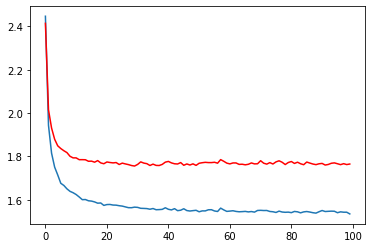

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

# Evaluate text generation

Check what the outputted text looks like

In [23]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

Thank the own sing was eye and cannot son'st him stands, for plainty never a from my friar you, by the honeds he's light, cold shall be these laws,
To have offence
And shall night my Parory's ways whom youls for it, here unswey such she is have;
For I'll life to hour Hereford on his blood not have excred the dead was of this did you fill the cockey my offended to liencht the worsing of mine, we formed.

BENVOLIO:
The more makes on, this now so cause's, grally all here your parding of my Lantertain'd in forgend these thrius, but you was be he leaves, but love him men that this lighted had not lost are be claid or excep, have well before hum!
And have his news.

BUCKINGHAM:
By me thy headful hum;
Will lord, so I have have a life banishing for she all be child in stries is sees;
But be underses in my hat to the forton, the lave death, that her know me this may anyinght me but not here need?

KING RICHARD III:
I prison?

KING EDWARD IV:
Means have the can you.

Lonce beat you.

ARWICLARET:

# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.

In [26]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type="gru", n_layers=2).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 24s (50 1%) train loss: 2.0572, test_loss: 2.0937]
Wheartrevers of to ared ktap, gear douth hit and greage with matte,
The you he tens mere, and; be hill 

 49s (100 2%) train loss: 1.7930, test_loss: 1.8840]
Which nrangthere.

DUKEN VINCENTIO:
I will the hear her, whill for stracks lame and suming bring,
Wher 

 13s (150 3%) train loss: 1.6362, test_loss: 1.7862]
Whothift foul great him after not.
We heard! I lord nor earian and my from know'sh
My more but my arm  

 38s (200 4%) train loss: 1.6057, test_loss: 1.6976]
Why,
Eperselse of he had the prust? From have fortune
The sir, Clawelf thou there to she venger,
And c 

 2s (250 5%) train loss: 1.5540, test_loss: 1.7570]
When are what!
Your slets every, I and I hass my lad here
As my heart a bemqueaul father country.

Thi 

 27s (300 6%) train loss: 1.5219, test_loss: 1.6923]
Wherity dien
That there to Harse falsed with for my leave
of the king the both height your carrance re 

 51s (350 7%) train loss: 

KeyboardInterrupt: ignored

In [ ]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type="lstm", n_layers=1).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 22s (50 1%) train loss: 2.0750, test_loss: 2.1123]
Wher the make shour whald you smadt, wist her in my lave foull som seat:
Am sie that, Ione to brome th 

 45s (100 2%) train loss: 1.9011, test_loss: 1.9441]
Wherind men gound
Engerains,
The sonling shall the me in thy lave dear knisenvy was gown
Where the som 

 7s (150 3%) train loss: 1.7445, test_loss: 1.8612]
Where, with the lothose too when there am you know'd, for gerate I heer the fave waids with thou can t 

 29s (200 4%) train loss: 1.7025, test_loss: 1.8249]
Which her most wat him I to pight for not we am it; there would you gracese,
Which hose him thy lord,  

 52s (250 5%) train loss: 1.6440, test_loss: 1.7721]
What I apey strange before thou righ therefore you reath three that the great, and with graces and nob 

 14s (300 6%) train loss: 1.6204, test_loss: 1.7773]
Where a some betite your brack meet the brother you the body. For him think and compay the mornous too 

 37s (350 7%) train loss: 